In [224]:
words = open('names.txt').read().splitlines()

In [225]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}

In [226]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [227]:
def build_dataset(words):
    block_size = 3
    X, Y = [], []
    for w in words:
        # print(w)
        context = [0] * block_size

        for c in w + '.':
            ix = stoi[c]
            X.append(context)
            Y.append(ix)

            # print(''.join(itos[i] for i in context), '---->', itos[ix])
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

X, Y = build_dataset(words)

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev= build_dataset(words[n1:n2])
Xtr, Ytr = build_dataset(words[n2:])

In [228]:
n1

25626

In [229]:
C = torch.randn((27, 2))

In [230]:
emb = C[X]
emb.shape

torch.Size([228146, 3, 2])

In [231]:
W1 = torch.randn((6, 100))
B1 = torch.randn(100)

In [232]:
h = torch.tanh(emb.view(emb.shape[0], 6) @ W1 + B1)

In [233]:
W2 = torch.randn((100, 27))
B2 = torch.randn(27)


In [234]:
logits = h @ W2 + B2
logits

tensor([[  7.8401,   0.3633,   9.2458,  ...,  -4.7086,  12.8443,  -5.3821],
        [ 11.5771,  -7.9920,  12.6336,  ..., -16.4817,  -2.6905, -11.8578],
        [  5.7026,   7.3276,   4.9297,  ...,   1.1914,   6.3984,   8.6635],
        ...,
        [  7.1865, -16.3274,   4.8290,  ..., -13.1037,  -1.3280, -16.3146],
        [  4.5999,  -0.7166,   2.1167,  ...,  -6.5376,  -3.1949,   1.1060],
        [ -3.6250,   5.2802,   5.6743,  ...,   3.0818,  -7.4019,   9.6276]])

In [235]:
counts = logits.exp()

In [236]:
prob = counts / counts.sum(1, keepdim=True)
prob.shape

torch.Size([228146, 27])

In [237]:
# loss = -prob[torch.arange(32), Y].log().mean()
# loss

In [238]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

for p in parameters: p.requires_grad = True

In [239]:
sum(p.nelement() for p in parameters)

11897

In [240]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10 ** lre

In [241]:
torch.device("cuda")

device(type='cuda')

In [242]:
torch.device('cpu')

device(type='cpu')

In [243]:
lri = []
lossi = []
stepi = []

In [244]:
# forward pass
for i in range(50000):
    # minibatch 
    ix = torch.randint(0, Xtr.shape[0], (32,))

    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])
    # print(loss.item())

    for p in parameters:
        p.grad = None

    loss.backward()

    # lr = lrs[i]
    lr = 0.1
    for p in parameters:
        p.data += -lr * p.grad
    
    stepi.append(i)
    lossi.append(loss.log10().item())

loss.item()

1.8977916240692139

In [245]:
emb = C[Xtr]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss.item()

2.0730464458465576

In [246]:
emb = C[Xdev]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss.item()

RuntimeError: mat1 and mat2 shapes cannot be multiplied (113275x6 and 30x200)

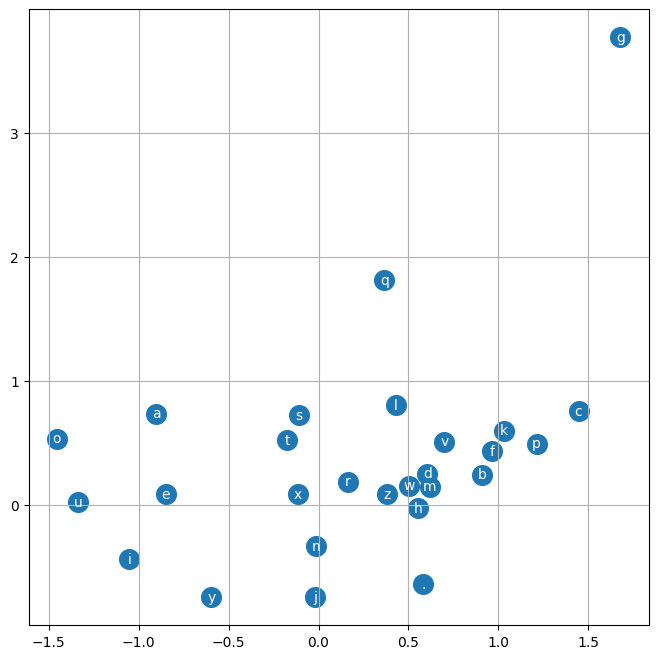

In [ ]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i, 0].item(), C[i, 1].item(), itos[i], ha="center", va="center", color="white")
plt.grid('white')

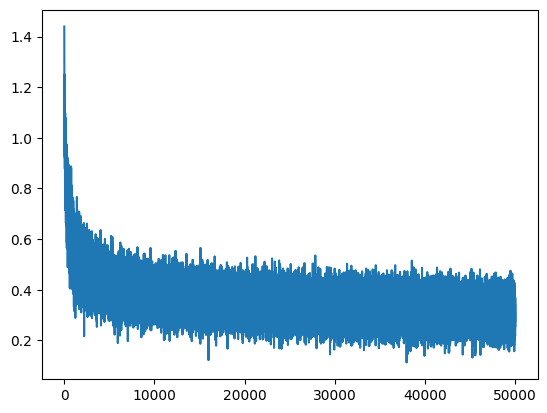

In [247]:
plt.plot(stepi, lossi)

In [ ]:
loss.item()

2.531444549560547

In [ ]:
# F.cross_entropy(logits, Y)